In [1]:
import numpy as np
import pandas as pd
from functions import *
from schemes import *
from plot import * 
from Kepler import *
from adaptive import *

%matplotlib inline

In [2]:
def solver(T, C, hlim, r0s, v0s, G, masses, h0 = 0.01, t0 = 0):
    
    # reposition centre of mass to origin with no momentum 
    rcom, vcom = CentreOfMass(r0s, v0s, masses)
    r0s -= rcom
    v0s -= vcom
    
    # Make a copy of initial values
    rs = np.copy(r0s)
    vs = np.copy(v0s)
    t = t0
    h = h0
    
    # Initialize our saved trajectories to be blank 
    t_vals = [t0]
    rs_traj = [r0s] 
    vs_traj = [v0s] 
    E_traj = [TotalEnergy(r0s, v0s, G, masses)]
    am_traj = [AngMomentum(r0s, v0s, masses)]
    times = 0 
    
    E0 = np.sum(E_traj[0])
    E0hat = E0 
    
    ## conditions to avoid dividing by zero 
    if E0hat == 0: E0hat = np.max(np.abs(E_traj[0])) 
    if E0hat == 0: E0hat = 1

    def maxDist(rs):
        d = -1
        n = len(rs)
        for i in range(0,n-1): 
            for j in range(i, n):
                d = max(d, np.linalg.norm(rs[i]-rs[j]))
        return d

    rs, vs = PEFRLStep(rs, vs, h, G, masses) 
    
    # run scheme for requried number of steps 
    while t <= T:
        t1 = time.time()

        h = C * findh(rs, vs) # proposed timestep

        rs_bar, vs_bar = PEFRLStep(rs, vs, h, G, masses)
        h_bar = C * findh(rs_bar, vs_bar) # proposed timestep

        h_new = (h + h_bar) / 2
        
        rs, vs = PEFRLStep(rs, vs, h_new, G, masses)

        times += time.time() - t1

        E = TotalEnergy(rs, vs, G, masses) # Calculate Energy 
        am = AngMomentum(rs, vs, masses) # Calculate angular momentum 
        
        if h_new < hlim: 
            reason = 2
        if t+h_new > T: 
            reason =  1
        if np.abs(np.sum(E) - E0) / np.abs(E0hat) > 0.01:
            reason = 3
        if maxDist(rs) > 10:
            reason = 0
        
        t += h_new

        ## append values to trajectories 
        t_vals = t_vals + [t]
        rs_traj = rs_traj + [rs] 
        vs_traj = vs_traj + [vs]
        E_traj = E_traj + [E]
        am_traj = am_traj + [am]
        
    # Make trajectories into numpy arrays
    rs_traj = np.array(rs_traj)
    vs_traj = np.array(vs_traj) 
    E_traj = np.array(E_traj)
    am_traj = np.array(am_traj)
    
    # reposition centre of mass to origin with no momentum 
    rs_traj = np.array([rs + rcom for rs in rs_traj])
    vs_traj = np.array([vs + vcom for vs in vs_traj])
    
    return (t_vals, rs_traj, vs_traj, E_traj, am_traj, times), reason

def findStability(T, C, hlim, Elim, r0s, v0s, G, masses, h0 = 0.01, t0 = 0):
    
    # reposition centre of mass to origin with no momentum 
    rcom, vcom = CentreOfMass(r0s, v0s, masses)
    r0s -= rcom
    v0s -= vcom
    
    # Make a copy of initial values
    rs = np.copy(r0s)
    vs = np.copy(v0s)
    t = t0
    h = h0
    
    E_traj = [TotalEnergy(r0s, v0s, G, masses)]
    
    E0 = np.sum(E_traj[0])
    E0hat = E0 
    
    ## conditions to avoid dividing by zero 
    if E0hat == 0: E0hat = np.max(np.abs(E_traj[0])) 
    if E0hat == 0: E0hat = 1

    def maxDist(rs):
        d = -1
        n = len(rs)
        for i in range(0,n-1): 
            for j in range(i, n):
                d = max(d, np.linalg.norm(rs[i]-rs[j]))
        return d

    rs, vs = PEFRLStep(rs, vs, h, G, masses) 
    
    # run scheme for requried number of steps 
    while t <= T:
        h = C * findh(rs, vs) # proposed timestep

        rs_bar, vs_bar = PEFRLStep(rs, vs, h, G, masses)
        h_bar = C * findh(rs_bar, vs_bar) # proposed timestep

        h_new = (h + h_bar) / 2
        
        rs, vs = PEFRLStep(rs, vs, h_new, G, masses)

        E = TotalEnergy(rs, vs, G, masses) # Calculate Energy 
        
        if h_new < hlim: 
            reason = 2
            break 
        if t+h_new > T: 
            reason =  1
            break 
        if np.abs(np.sum(E) - E0) / np.abs(E0hat) > Elim:
            reason = 3
            break 
        if maxDist(rs) > 10:
            reason = 0
            break 
        
        t += h_new
    
    return reason, t

In [3]:
# gravity
G = 1

m1 = 1 
m2 = 1 
m3 = 1

R = 1

# position
r1 = np.array([-R,0.0,0.0], dtype="float64")
r2 = np.array([0,0.0,0.0], dtype="float64")
r3 = np.array([R,0.0,0.0], dtype="float64")

px = 0.347111
py = 0.532728

# velocity 
v1 = np.array([px,py,0], dtype="float64")
v2 = np.array([-2 * px,-2*py,0], dtype="float64")
v3 = np.array([px,py,0], dtype="float64")

# create initial vectors
r0s = np.array([r1,r2,r3])
v0s = np.array([v1,v2,v3])
masses = np.array([m1, m2, m3])

In [4]:
T = 1000
hlim = 1e-3
Elim = 0.01
C = 0.1

In [5]:
def findR(v0s, E0, masses):
    ke = np.sum(KineticEnergy(v0s, masses))
    R = 5 / (2 * (ke - E0))
    return R

In [14]:
exs = np.round(np.arange(-2,1.1,.1), 3)
eys = np.round(np.arange(-2,1.1,.1), 3)

E0 = np.sum(TotalEnergy(r0s, v0s, G, masses))

stabilities = []
for ex in exs:
    for ey in eys:
        pxhat = px + ex
        pyhat = py + ey

        # velocity 
        v1hat = np.array([pxhat,pyhat,0], dtype="float64")
        v2hat = np.array([-2 * pxhat,-2*pyhat,0], dtype="float64")
        v3hat = np.array([pxhat,pyhat,0], dtype="float64")
        v0shat = np.array([v1hat,v2hat,v3hat])

        R = findR(v0shat, E0, masses)
        
        # position
        r1hat = np.array([-R,0.0,0.0], dtype="float64")
        r2hat = np.array([0,0.0,0.0], dtype="float64")
        r3hat = np.array([R,0.0,0.0], dtype="float64")
        r0shat = np.array([r1hat,r2hat,r3hat])
        
        # print(np.sum(TotalEnergy(r0shat, v0shat, G, masses)) - E0)

        if (ex == 0) and (ey == 0): print('R', R)

        stability = findStability(T, C, hlim, Elim, r0shat, v0shat, G, masses)

        stabilities.append(stability)

stabilities = np.array(stabilities).reshape(len(exs), len(eys))


R 1.0


In [35]:
import pandas as pd 
df = pd.DataFrame(stabilities)
df.to_csv("Data/Fig8/Fig8_Stability_ZoomedOut.csv")

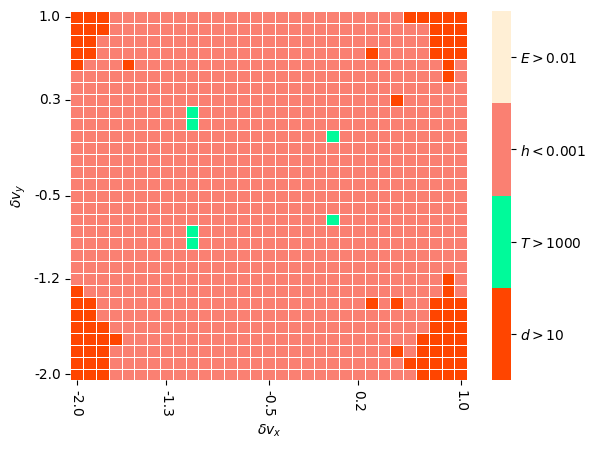

In [33]:
import seaborn as sns
from matplotlib.colors import ListedColormap


# Create a figure and axis for the heatmap
fig, ax = plt.subplots()

cmap = ListedColormap(['orangered','mediumspringgreen','salmon','papayawhip'])
# cmap = sns.color_palette('tab10', n_colors=4)

# Create the heatmap using Seaborn
sns.heatmap(stabilities,cmap = cmap,  cbar=True, ax=ax, vmin=0, vmax=3, linewidths = .5)

ax.set_xticks(np.arange(len(exs)))
ax.set_yticks(np.arange(len(eys)))
ax.set_xticklabels(exs, rotation = 270)
ax.set_yticklabels(eys, rotation = 0)

# Determine the tick positions
num_ticks = 5
tick_positions = np.linspace(0, stabilities.shape[0] - 1, num_ticks, dtype=int) 

# Set the tick positions and labels for both x-axis and y-axis
ax.set_xticks(tick_positions + 0.5)
ax.set_yticks(tick_positions + 0.5)
ax.set_xticklabels(exs[tick_positions])
ax.set_yticklabels(eys[tick_positions])

# Set axis labels and title
ax.set_xlabel(f'$\delta v_x$')
ax.set_ylabel('$\delta v_y$')

colorbar = ax.collections[0].colorbar
colorbar.set_ticks(0.375 * np.array([1, 3, 5, 7]))
colorbar.set_ticklabels(['$d > 10$', '$T > {1000}}$', '$h < 0.001$', '$E > 0.01$'])

# Show the plot
plt.show()


#### Finer Resolution

In [42]:
exs = np.round(np.arange(-0.1,0.11,0.01), 3)
eys = np.flip(np.round(np.arange(-0.1,0.11,0.01), 3))

E0 = np.sum(TotalEnergy(r0s, v0s, G, masses))

stabilities2 = []
for ex in exs:
    for ey in eys:
        print(ex, ey)
        pxhat = px + ex
        pyhat = py + ey

        # velocity 
        v1hat = np.array([pxhat,pyhat,0], dtype="float64")
        v2hat = np.array([-2 * pxhat,-2*pyhat,0], dtype="float64")
        v3hat = np.array([pxhat,pyhat,0], dtype="float64")
        v0shat = np.array([v1hat,v2hat,v3hat])

        R = findR(v0shat, E0, masses)
        
        # position
        r1hat = np.array([-R,0.0,0.0], dtype="float64")
        r2hat = np.array([0,0.0,0.0], dtype="float64")
        r3hat = np.array([R,0.0,0.0], dtype="float64")
        r0shat = np.array([r1hat,r2hat,r3hat])
        
        # print(np.sum(TotalEnergy(r0shat, v0shat, G, masses)) - E0)

        if (ex == 0) and (ey == 0): print('R', R)

        stability = findStability(T, C, hlim, Elim, r0shat, v0shat, G, masses)

        stabilities2.append(stability)

stabilities2 = np.array(stabilities2).reshape(len(exs), len(eys))

-0.1 0.1
-0.1 0.09
-0.1 0.08
-0.1 0.07
-0.1 0.06
-0.1 0.05
-0.1 0.04
-0.1 0.03
-0.1 0.02
-0.1 0.01
-0.1 -0.0
-0.1 -0.01
-0.1 -0.02
-0.1 -0.03
-0.1 -0.04
-0.1 -0.05
-0.1 -0.06
-0.1 -0.07
-0.1 -0.08
-0.1 -0.09
-0.1 -0.1
-0.09 0.1
-0.09 0.09
-0.09 0.08
-0.09 0.07
-0.09 0.06
-0.09 0.05
-0.09 0.04
-0.09 0.03
-0.09 0.02
-0.09 0.01
-0.09 -0.0
-0.09 -0.01
-0.09 -0.02
-0.09 -0.03
-0.09 -0.04
-0.09 -0.05
-0.09 -0.06
-0.09 -0.07
-0.09 -0.08
-0.09 -0.09
-0.09 -0.1
-0.08 0.1
-0.08 0.09
-0.08 0.08
-0.08 0.07
-0.08 0.06
-0.08 0.05
-0.08 0.04
-0.08 0.03
-0.08 0.02
-0.08 0.01
-0.08 -0.0
-0.08 -0.01
-0.08 -0.02
-0.08 -0.03
-0.08 -0.04
-0.08 -0.05
-0.08 -0.06
-0.08 -0.07
-0.08 -0.08
-0.08 -0.09
-0.08 -0.1
-0.07 0.1
-0.07 0.09
-0.07 0.08
-0.07 0.07
-0.07 0.06
-0.07 0.05
-0.07 0.04
-0.07 0.03
-0.07 0.02
-0.07 0.01
-0.07 -0.0
-0.07 -0.01
-0.07 -0.02
-0.07 -0.03
-0.07 -0.04
-0.07 -0.05
-0.07 -0.06
-0.07 -0.07
-0.07 -0.08
-0.07 -0.09
-0.07 -0.1
-0.06 0.1
-0.06 0.09
-0.06 0.08
-0.06 0.07
-0.06 0.06
-0.06 0.05


In [43]:
import pandas as pd 
df = pd.DataFrame(stabilities2)
df.to_csv("Data/Fig8/Fig8_Stability.csv")

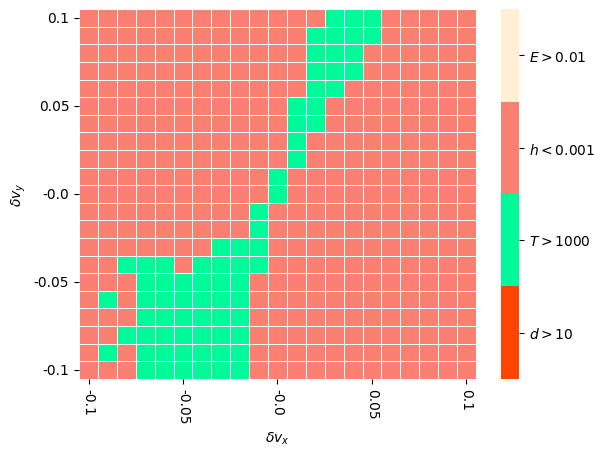

In [44]:
import seaborn as sns
from matplotlib.colors import ListedColormap


# Create a figure and axis for the heatmap
fig, ax = plt.subplots()

cmap = ListedColormap(['orangered','mediumspringgreen','salmon','papayawhip'])
# cmap = sns.color_palette('tab10', n_colors=4)

# Create the heatmap using Seaborn
sns.heatmap(stabilities2,cmap = cmap,  cbar=True, ax=ax, vmin=0, vmax=3, linewidths = .5)

ax.set_xticks(np.arange(len(exs)))
ax.set_yticks(np.arange(len(eys)))
ax.set_xticklabels(exs, rotation = 270)
ax.set_yticklabels(eys, rotation = 0)

# Determine the tick positions
num_ticks = 5
tick_positions = np.linspace(0, stabilities2.shape[0] - 1, num_ticks, dtype=int) 

# Set the tick positions and labels for both x-axis and y-axis
ax.set_xticks(tick_positions + 0.5)
ax.set_yticks(tick_positions + 0.5)
ax.set_xticklabels(exs[tick_positions])
ax.set_yticklabels(eys[tick_positions])

# Set axis labels and title
ax.set_xlabel(f'$\delta v_x$')
ax.set_ylabel('$\delta v_y$')

colorbar = ax.collections[0].colorbar
colorbar.set_ticks(0.375 * np.array([1, 3, 5, 7]))
colorbar.set_ticklabels(['$d > 10$', '$T > {1000}}$', '$h < 0.001$', '$E > 0.01$'])

# Show the plot
plt.show()

### Finer Still 

In [6]:
C = 0.2
exs = np.linspace(-0.3,0.3,100)
eys = np.flip(np.linspace(-0.3, 0.3, 100))

In [7]:
E0 = np.sum(TotalEnergy(r0s, v0s, G, masses))

stabilities3 = []
ts = []
for ex in exs:
    for ey in eys:
        print(ex, ey)
        pxhat = px + ex
        pyhat = py + ey

        # velocity 
        v1hat = np.array([pxhat,pyhat,0], dtype="float64")
        v2hat = np.array([-2 * pxhat,-2*pyhat,0], dtype="float64")
        v3hat = np.array([pxhat,pyhat,0], dtype="float64")
        v0shat = np.array([v1hat,v2hat,v3hat])

        R = findR(v0shat, E0, masses)
        
        # position
        r1hat = np.array([-R,0.0,0.0], dtype="float64")
        r2hat = np.array([0,0.0,0.0], dtype="float64")
        r3hat = np.array([R,0.0,0.0], dtype="float64")
        r0shat = np.array([r1hat,r2hat,r3hat])
        
        # print(np.sum(TotalEnergy(r0shat, v0shat, G, masses)) - E0)

        if (ex == 0) and (ey == 0): print('R', R)

        stability, escapet = findStability(T, C, hlim, Elim, r0shat, v0shat, G, masses)

        stabilities3.append(stability)
        ts.append(escapet)

-0.3 0.3
-0.3 0.293939393939394
-0.3 0.2878787878787879
-0.3 0.2818181818181818
-0.3 0.2757575757575758
-0.3 0.2696969696969697
-0.3 0.2636363636363636
-0.3 0.2575757575757576
-0.3 0.2515151515151515
-0.3 0.24545454545454543
-0.3 0.23939393939393944
-0.3 0.23333333333333334
-0.3 0.22727272727272724
-0.3 0.22121212121212125
-0.3 0.21515151515151515
-0.3 0.20909090909090905
-0.3 0.20303030303030306
-0.3 0.19696969696969696
-0.3 0.19090909090909092
-0.3 0.18484848484848487
-0.3 0.17878787878787877
-0.3 0.17272727272727273
-0.3 0.16666666666666669
-0.3 0.16060606060606064
-0.3 0.15454545454545454
-0.3 0.1484848484848485
-0.3 0.14242424242424245
-0.3 0.13636363636363635
-0.3 0.1303030303030303
-0.3 0.12424242424242427
-0.3 0.11818181818181817
-0.3 0.11212121212121212
-0.3 0.10606060606060608
-0.3 0.10000000000000003
-0.3 0.09393939393939393
-0.3 0.08787878787878789
-0.3 0.08181818181818185
-0.3 0.07575757575757575
-0.3 0.0696969696969697
-0.3 0.06363636363636366
-0.3 0.05757575757575761
-0.

In [ ]:
stabilities3 = np.array(stabilities3).reshape(len(exs), len(eys))

import pandas as pd 
df = pd.DataFrame(stabilities3)
df.to_csv("Data/Fig8/Fig8_Stability2.csv")

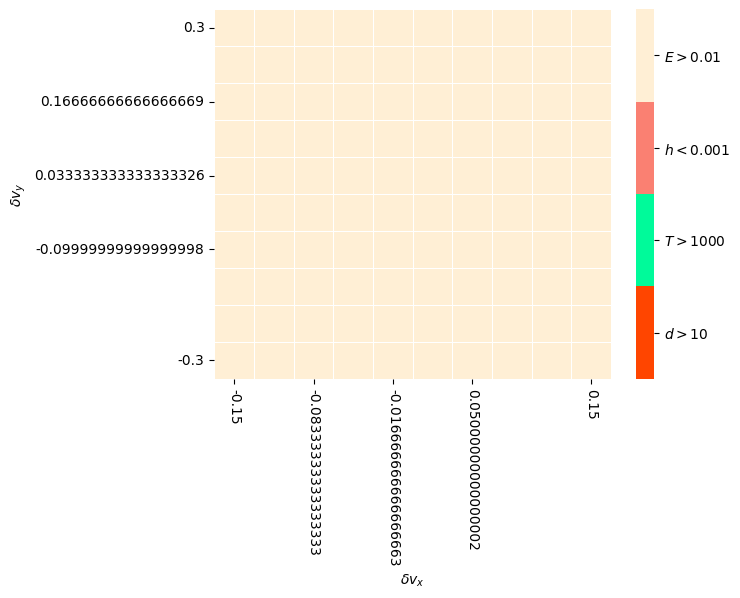

In [ ]:
import seaborn as sns
from matplotlib.colors import ListedColormap


# Create a figure and axis for the heatmap
fig, ax = plt.subplots()

cmap = ListedColormap(['orangered','mediumspringgreen','salmon','papayawhip'])
# cmap = sns.color_palette('tab10', n_colors=4)

# Create the heatmap using Seaborn
sns.heatmap(stabilities3,cmap = cmap,  cbar=True, ax=ax, vmin=0, vmax=3, linewidths = .5)

ax.set_xticks(np.arange(len(exs)))
ax.set_yticks(np.arange(len(eys)))
ax.set_xticklabels(exs, rotation = 270)
ax.set_yticklabels(eys, rotation = 0)

# Determine the tick positions
num_ticks = 5
tick_positions = np.linspace(0, stabilities3.shape[0] - 1, num_ticks, dtype=int) 

# Set the tick positions and labels for both x-axis and y-axis
ax.set_xticks(tick_positions + 0.5)
ax.set_yticks(tick_positions + 0.5)
ax.set_xticklabels(exs[tick_positions])
ax.set_yticklabels(eys[tick_positions])

# Set axis labels and title
ax.set_xlabel(f'$\delta v_x$')
ax.set_ylabel('$\delta v_y$')

colorbar = ax.collections[0].colorbar
colorbar.set_ticks(0.375 * np.array([1, 3, 5, 7]))
colorbar.set_ticklabels(['$d > 10$', '$T > {1000}}$', '$h < 0.001$', '$E > 0.01$'])

# Show the plot
plt.show()

### AGAIN!!

In [ ]:
C = 0.2
exs = np.linspace(-0.3,0.3,500)
eys = np.flip(np.linspace(-0.3, 0.3, 500))

In [ ]:
E0 = np.sum(TotalEnergy(r0s, v0s, G, masses))

stabilities4 = []
ts4 = []
for ex in exs:
    for ey in eys:
        print(ex, ey)
        pxhat = px + ex
        pyhat = py + ey

        # velocity 
        v1hat = np.array([pxhat,pyhat,0], dtype="float64")
        v2hat = np.array([-2 * pxhat,-2*pyhat,0], dtype="float64")
        v3hat = np.array([pxhat,pyhat,0], dtype="float64")
        v0shat = np.array([v1hat,v2hat,v3hat])

        R = findR(v0shat, E0, masses)
        
        # position
        r1hat = np.array([-R,0.0,0.0], dtype="float64")
        r2hat = np.array([0,0.0,0.0], dtype="float64")
        r3hat = np.array([R,0.0,0.0], dtype="float64")
        r0shat = np.array([r1hat,r2hat,r3hat])
        
        # print(np.sum(TotalEnergy(r0shat, v0shat, G, masses)) - E0)

        if (ex == 0) and (ey == 0): print('R', R)

        stability, escapet = findStability(T, C, hlim, Elim, r0shat, v0shat, G, masses)

        stabilities4.append(stability)
        ts4.append(escapet)

In [ ]:
stabilities4 = np.array(stabilities4).reshape(len(exs), len(eys))

import pandas as pd 
df = pd.DataFrame(stabilities4)
df.to_csv("Data/Fig8/Fig8_Stability3.csv")

In [ ]:
import seaborn as sns
from matplotlib.colors import ListedColormap


# Create a figure and axis for the heatmap
fig, ax = plt.subplots()

cmap = ListedColormap(['orangered','mediumspringgreen','salmon','papayawhip'])
# cmap = sns.color_palette('tab10', n_colors=4)

# Create the heatmap using Seaborn
sns.heatmap(stabilities3,cmap = cmap,  cbar=True, ax=ax, vmin=0, vmax=3, linewidths = .5)

ax.set_xticks(np.arange(len(exs)))
ax.set_yticks(np.arange(len(eys)))
ax.set_xticklabels(exs, rotation = 270)
ax.set_yticklabels(eys, rotation = 0)

# Determine the tick positions
num_ticks = 5
tick_positions = np.linspace(0, stabilities3.shape[0] - 1, num_ticks, dtype=int) 

# Set the tick positions and labels for both x-axis and y-axis
ax.set_xticks(tick_positions + 0.5)
ax.set_yticks(tick_positions + 0.5)
ax.set_xticklabels(exs[tick_positions])
ax.set_yticklabels(eys[tick_positions])

# Set axis labels and title
ax.set_xlabel(f'$\delta v_x$')
ax.set_ylabel('$\delta v_y$')

colorbar = ax.collections[0].colorbar
colorbar.set_ticks(0.375 * np.array([1, 3, 5, 7]))
colorbar.set_ticklabels(['$d > 10$', '$T > {1000}}$', '$h < 0.001$', '$E > 0.01$'])

# Show the plot
plt.show()